In [2]:
# 1. 환경 설정 및 데이터 로드

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shutil
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 원본 데이터 경로
DATA_PATH = '../data/PCB_DATASET/'
IMAGE_PATH = os.path.join(DATA_PATH, 'images')

# 출력 경로
PROCESSED_PATH = '../processed_data/'

# 결함 클래스 정의
DEFECT_CLASSES = [
    'Missing_hole',      # 구멍 누락
    'Mouse_bite',        # 마우스 바이트
    'Open_circuit',      # 단선
    'Short',             # 합선
    'Spur',              # 돌기
    'Spurious_copper'    # 이물질 구리
]

print(f"\n 결함 클래스")
for i, defect in enumerate(DEFECT_CLASSES, 1):
    print(f"   {i}. {defect}")



 결함 클래스
   1. Missing_hole
   2. Mouse_bite
   3. Open_circuit
   4. Short
   5. Spur
   6. Spurious_copper


In [4]:
# 2. 메타데이터 생성 및 라벨 파일 확인

import xml.etree.ElementTree as ET

# 데이터 경로
IMAGE_PATH = os.path.join(DATA_PATH, 'images')
ANNO_PATH = os.path.join(DATA_PATH, 'Annotations')

# 각 이미지와 라벨 정보 수집
image_info = []

for defect_class in DEFECT_CLASSES:
    image_class_path = os.path.join(IMAGE_PATH, defect_class)
    anno_class_path = os.path.join(ANNO_PATH, defect_class)
    
    image_files = sorted([f for f in os.listdir(image_class_path) 
                         if f.endswith(('.jpg', '.png'))])
    
    for img_file in image_files:
        # XML 파일명 (확장자만 다름)
        xml_file = img_file.replace('.jpg', '.xml').replace('.png', '.xml')
        xml_path = os.path.join(anno_class_path, xml_file)
        
        # XML 파일 존재 확인
        if os.path.exists(xml_path):
            image_info.append({
                'filename': img_file,
                'class': defect_class,
                'class_id': DEFECT_CLASSES.index(defect_class),
                'image_path': os.path.join(image_class_path, img_file),
                'xml_path': xml_path
            })

df = pd.DataFrame(image_info)

print(f"\n총 이미지 수: {len(df)}개")
print(f"\n클래스별 분포:")
print(df['class'].value_counts().sort_index())

print(f"\n데이터 샘플 (처음 5개):")
print(df.head())

print(f"\nXML 라벨 파일 확인 완료")


총 이미지 수: 693개

클래스별 분포:
class
Missing_hole       115
Mouse_bite         115
Open_circuit       116
Short              116
Spur               115
Spurious_copper    116
Name: count, dtype: int64

데이터 샘플 (처음 5개):
                 filename         class  class_id  \
0  01_missing_hole_01.jpg  Missing_hole         0   
1  01_missing_hole_02.jpg  Missing_hole         0   
2  01_missing_hole_03.jpg  Missing_hole         0   
3  01_missing_hole_04.jpg  Missing_hole         0   
4  01_missing_hole_05.jpg  Missing_hole         0   

                                          image_path  \
0  ../data/PCB_DATASET/images\Missing_hole\01_mis...   
1  ../data/PCB_DATASET/images\Missing_hole\01_mis...   
2  ../data/PCB_DATASET/images\Missing_hole\01_mis...   
3  ../data/PCB_DATASET/images\Missing_hole\01_mis...   
4  ../data/PCB_DATASET/images\Missing_hole\01_mis...   

                                            xml_path  
0  ../data/PCB_DATASET/Annotations\Missing_hole\0...  
1  ../data/PCB_DATASET

In [6]:
# 3. Train/Test 분할

# 전처리 파라미터
TARGET_SIZE = 416
TRAIN_RATIO = 0.8
RANDOM_SEED = 42

print(f"Train 비율: {int(TRAIN_RATIO * 100)}%")
print(f"Test 비율: {int((1 - TRAIN_RATIO) * 100)}%")
print(f"Random Seed: {RANDOM_SEED}\n")

np.random.seed(RANDOM_SEED)

train_list = []
test_list = []

# 클래스별로 분할
for defect_class in DEFECT_CLASSES:
    # 해당 클래스 데이터만 추출
    class_df = df[df['class'] == defect_class].copy()
    
    # 랜덤 셔플
    class_df = class_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # 분할
    split_idx = int(len(class_df) * TRAIN_RATIO)
    train_df = class_df[:split_idx]
    test_df = class_df[split_idx:]
    
    train_list.append(train_df)
    test_list.append(test_df)
    
    print(f"{defect_class:20s}: Train {len(train_df):3d}개 | Test {len(test_df):3d}개")

# 합치기
train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"{'총합':20s}: Train {len(train_df):3d}개 | Test {len(test_df):3d}개")


Train 비율: 80%
Test 비율: 19%
Random Seed: 42

Missing_hole        : Train  92개 | Test  23개
Mouse_bite          : Train  92개 | Test  23개
Open_circuit        : Train  92개 | Test  24개
Short               : Train  92개 | Test  24개
Spur                : Train  92개 | Test  23개
Spurious_copper     : Train  92개 | Test  24개
총합                  : Train 552개 | Test 141개


In [7]:
# 4. Train 데이터 전처리 및 저장

import xml.etree.ElementTree as ET

print(f"Train 데이터 전처리")
print(f"목표 크기: {TARGET_SIZE} x {TARGET_SIZE}")
print(f"처리 대상: {len(train_df)}개 이미지\n")

# Train 폴더 생성
TRAIN_IMG_PATH = os.path.join(PROCESSED_PATH, 'train', 'images')
TRAIN_LABEL_PATH = os.path.join(PROCESSED_PATH, 'train', 'labels')

if os.path.exists(os.path.join(PROCESSED_PATH, 'train')):
    shutil.rmtree(os.path.join(PROCESSED_PATH, 'train'))

for defect_class in DEFECT_CLASSES:
    os.makedirs(os.path.join(TRAIN_IMG_PATH, defect_class), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_LABEL_PATH, defect_class), exist_ok=True)

print(f"폴더 생성 완료: train/images, train/labels\n")

# XML을 YOLO 형식으로 변환하는 함수
def xml_to_yolo(xml_path, orig_width, orig_height, target_size, class_id):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    yolo_lines = []
    
    for obj in root.findall('object'):
        # Bounding box 좌표
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        # 원본 좌표 -> 정규화 (0~1)
        x_center = ((xmin + xmax) / 2) / orig_width
        y_center = ((ymin + ymax) / 2) / orig_height
        width = (xmax - xmin) / orig_width
        height = (ymax - ymin) / orig_height
        
        # YOLO 형식: class_id x_center y_center width height
        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return yolo_lines

# 이미지 처리

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="진행", ncols=80):
    # 원본 이미지 로드
    img = cv2.imread(row['image_path'])
    orig_height, orig_width = img.shape[:2]
    
    # 리사이즈
    img_resized = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
    
    # 이미지 저장
    output_img_path = os.path.join(TRAIN_IMG_PATH, row['class'], row['filename'])
    cv2.imwrite(output_img_path, img_resized)
    
    # 라벨 변환 및 저장
    yolo_labels = xml_to_yolo(
        row['xml_path'], 
        orig_width, 
        orig_height, 
        TARGET_SIZE, 
        row['class_id']
    )
    
    # .txt 파일 저장
    label_filename = row['filename'].replace('.jpg', '.txt').replace('.png', '.txt')
    output_label_path = os.path.join(TRAIN_LABEL_PATH, row['class'], label_filename)
    
    with open(output_label_path, 'w') as f:
        f.write('\n'.join(yolo_labels))

print(f"\nTrain 데이터 전처리 완료")
print(f"   저장 위치: {os.path.join(PROCESSED_PATH, 'train')}")
print(f"   저장 개수: {len(train_df)}개")

Train 데이터 전처리
목표 크기: 416 x 416
처리 대상: 552개 이미지

폴더 생성 완료: train/images, train/labels



진행: 100%|███████████████████████████████████| 552/552 [00:40<00:00, 13.58it/s]


Train 데이터 전처리 완료
   저장 위치: ../processed_data/train
   저장 개수: 552개


In [8]:
# 5. Test 데이터 전처리 및 저장

print(f"Test 데이터 전처리")
print(f"목표 크기: {TARGET_SIZE} x {TARGET_SIZE}")
print(f"처리 대상: {len(test_df)}개 이미지\n")

# Test 폴더 생성
TEST_IMG_PATH = os.path.join(PROCESSED_PATH, 'test', 'images')
TEST_LABEL_PATH = os.path.join(PROCESSED_PATH, 'test', 'labels')

if os.path.exists(os.path.join(PROCESSED_PATH, 'test')):
    shutil.rmtree(os.path.join(PROCESSED_PATH, 'test'))

for defect_class in DEFECT_CLASSES:
    os.makedirs(os.path.join(TEST_IMG_PATH, defect_class), exist_ok=True)
    os.makedirs(os.path.join(TEST_LABEL_PATH, defect_class), exist_ok=True)

print(f"폴더 생성 완료: test/images, test/labels\n")

# 이미지 처리

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="진행", ncols=80):
    # 원본 이미지 로드
    img = cv2.imread(row['image_path'])
    orig_height, orig_width = img.shape[:2]
    
    # 리사이즈
    img_resized = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
    
    # 이미지 저장
    output_img_path = os.path.join(TEST_IMG_PATH, row['class'], row['filename'])
    cv2.imwrite(output_img_path, img_resized)
    
    # 라벨 변환 및 저장
    yolo_labels = xml_to_yolo(
        row['xml_path'], 
        orig_width, 
        orig_height, 
        TARGET_SIZE, 
        row['class_id']
    )
    
    # .txt 파일 저장
    label_filename = row['filename'].replace('.jpg', '.txt').replace('.png', '.txt')
    output_label_path = os.path.join(TEST_LABEL_PATH, row['class'], label_filename)
    
    with open(output_label_path, 'w') as f:
        f.write('\n'.join(yolo_labels))

print(f"\nTest 데이터 전처리 완료")
print(f"   저장 위치: {os.path.join(PROCESSED_PATH, 'test')}")
print(f"   저장 개수: {len(test_df)}개")

Test 데이터 전처리
목표 크기: 416 x 416
처리 대상: 141개 이미지

폴더 생성 완료: test/images, test/labels



진행: 100%|███████████████████████████████████| 141/141 [00:10<00:00, 13.18it/s]


Test 데이터 전처리 완료
   저장 위치: ../processed_data/test
   저장 개수: 141개


In [9]:
# 6. 전처리 결과 확인

# 저장된 파일 개수 확인
print(f"\n클래스별 저장된 파일 개수:")
print(f"{'클래스':<20s} {'Train':>8s} {'Test':>8s} {'합계':>8s}")
print("-" * 60)

total_train = 0
total_test = 0

for defect_class in DEFECT_CLASSES:
    train_count = len(os.listdir(os.path.join(TRAIN_PATH, defect_class)))
    test_count = len(os.listdir(os.path.join(TEST_PATH, defect_class)))
    
    total_train += train_count
    total_test += test_count
    
    print(f"{defect_class:<20s} {train_count:>8d} {test_count:>8d} {train_count + test_count:>8d}")

print("-" * 60)
print(f"{'총합':<20s} {total_train:>8d} {total_test:>8d} {total_train + total_test:>8d}")

# DataFrame과 실제 파일 개수 비교
print(f"\n비교 확인:")
print(f"  DataFrame Train: {len(train_df)}개 | 실제 파일: {total_train}개 {'ok' if len(train_df) == total_train else '❌'}")
print(f"  DataFrame Test: {len(test_df)}개 | 실제 파일: {total_test}개 {'ok' if len(test_df) == total_test else '❌'}")

# 샘플 이미지 크기 확인
print(f"\n샘플 이미지 크기 확인:")
sample_path = os.path.join(TRAIN_PATH, DEFECT_CLASSES[0], 
                           os.listdir(os.path.join(TRAIN_PATH, DEFECT_CLASSES[0]))[0])
sample_img = cv2.imread(sample_path)
print(f"  {sample_img.shape[1]} x {sample_img.shape[0]} {'ok' if sample_img.shape[:2] == (TARGET_SIZE, TARGET_SIZE) else '❌'}")



클래스별 저장된 파일 개수:
클래스                     Train     Test       합계
------------------------------------------------------------


NameError: name 'TRAIN_PATH' is not defined

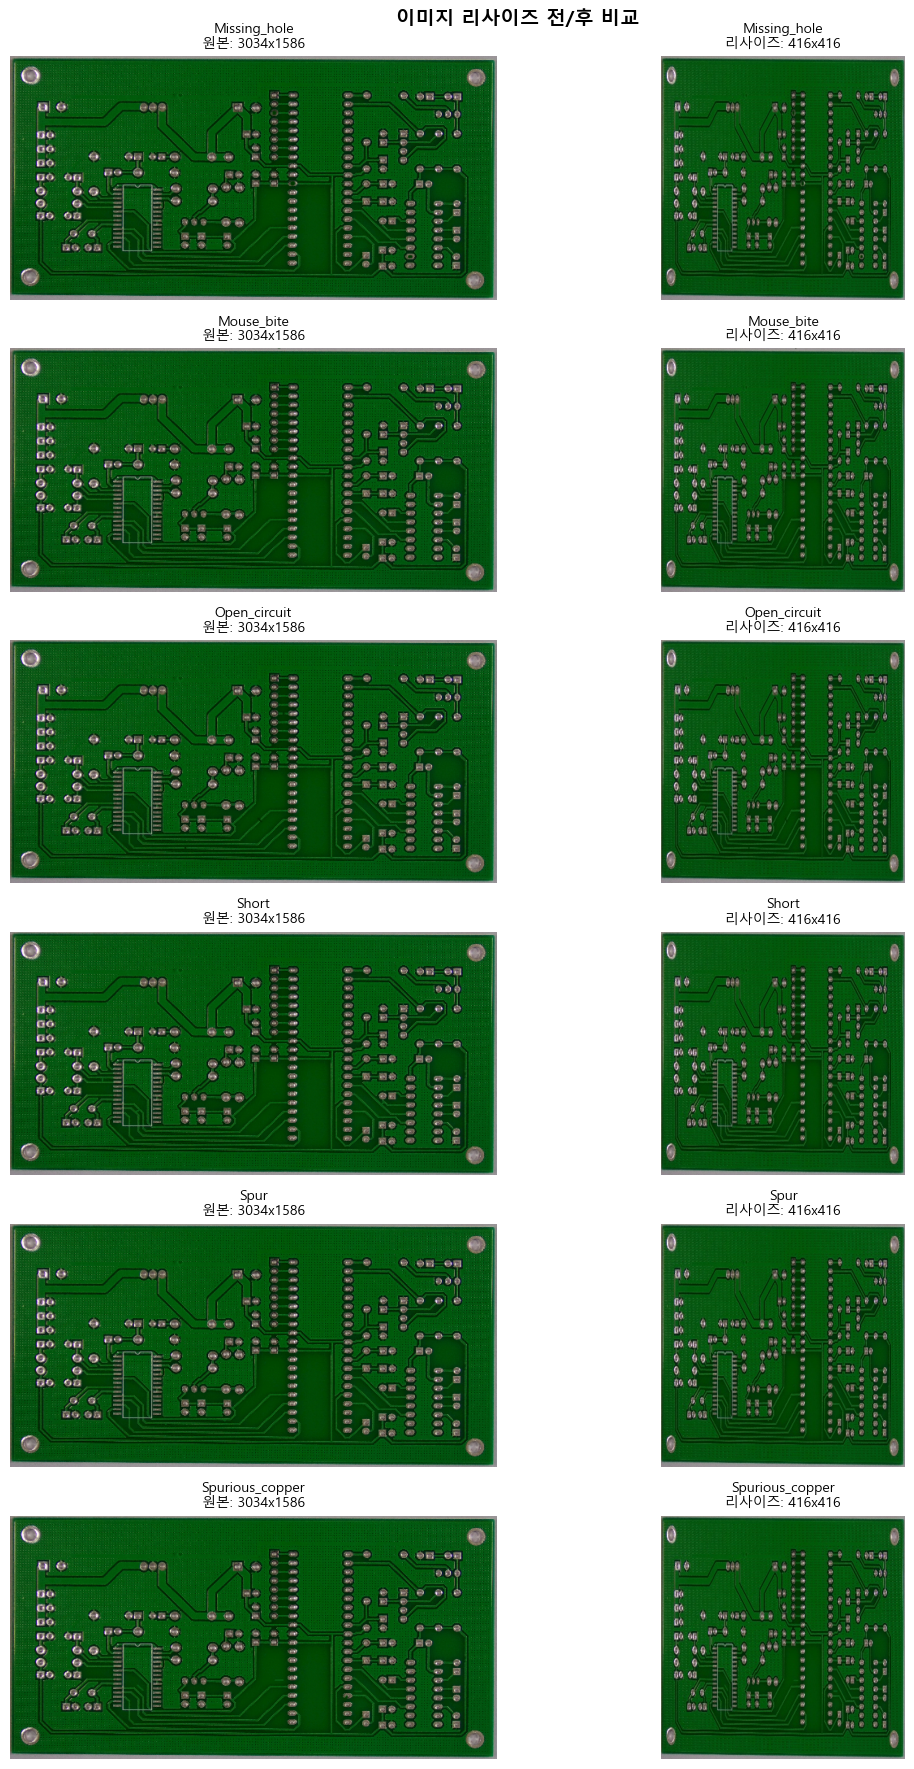

In [9]:
# 7. 전/후 비교 시각화


fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i, defect_class in enumerate(DEFECT_CLASSES):
    # 원본 이미지
    original_path = os.path.join(IMAGE_PATH, defect_class, 
                                 os.listdir(os.path.join(IMAGE_PATH, defect_class))[0])
    original_img = cv2.imread(original_path)
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 리사이즈된 이미지
    resized_path = os.path.join(TRAIN_PATH, defect_class,
                                os.listdir(os.path.join(TRAIN_PATH, defect_class))[0])
    resized_img = cv2.imread(resized_path)
    resized_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    
    # 원본 (축소해서 표시)
    axes[i, 0].imshow(cv2.resize(original_rgb, (600, 300)))
    axes[i, 0].set_title(f'{defect_class}\n원본: {original_img.shape[1]}x{original_img.shape[0]}',
                        fontsize=10)
    axes[i, 0].axis('off')
    
    # 리사이즈
    axes[i, 1].imshow(resized_rgb)
    axes[i, 1].set_title(f'{defect_class}\n리사이즈: {TARGET_SIZE}x{TARGET_SIZE}',
                        fontsize=10)
    axes[i, 1].axis('off')

plt.suptitle('이미지 리사이즈 전/후 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
